# Spectral Analysis of Temperature 12k records using `Pyleoclim` 

by [Alexander James](https://alexkjames.github.io)

In this notebook, we demonstrate how to use [Pyleoclim](https://medium.com/cyberpaleo/introducing-pyleoclim-paleoclimate-timeseries-analysis-and-visualization-with-python-5b33f384e93) to perform spectral analysis on the [Temperature 12k Database](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/noaa-recon-27330/html).

Technical skills involved:
- loading data in the [LiPD](https://lipd.net) format.
- applying and interpreting spectral analysis in Pyleoclim
- estimating scaling exponents from [PSD objects](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#psd-pyleoclim-psd)


First, let's import some useful packages, including `Pyleoclim`.

In [63]:
# load pacakges
%load_ext autoreload
%autoreload 2
    
import pyleoclim as pyleo
import os
import numpy as np
from tqdm import tqdm 
import pickle

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load LiPD files with `Pyleoclim`

The LiPD version of the dataset can be downloaded [here](http://lipdverse.org/globalHolocene/current_version/globalHolocene1_0_0.zip).
Note that the record "RainbowLake.Shuman.2016.lpd" is problematic and a fix of it can be downlowded [here](https://github.com/LinkedEarth/LiPDbooks/raw/master/notebooks/lipd/RainbowLake.Shuman.2016.lpd).

Suppose the LiPD files of the dataset are stored in the folder named "globalHolocene1_0_0", to load the whole dataset, simply use `pyleo.Lipd()` with its argument `usr_path` pointing to the relative path of the folder.
The resultant `dataset` is a LiPD utility object that has a method called `to_tso()`, which will extract the timeseries records to a Python list for us.

In [64]:
# load the LiPD dataset
dataset = pyleo.Lipd(usr_path='../data/Temp12k1_1_0')

# convert the input dataset into a list of LiPD timeseries objects,
# each object is essentially a dictionary
ts_list = dataset.to_tso()

Disclaimer: LiPD files may be updated and modified to adhere to standards

Found: 697 LiPD file(s)
reading: MilandreCave.Affolter.2019.lpd
reading: Hams.Bennett.1987.lpd
reading: EagleTarn.Rees.2010.lpd
reading: HjortSo.Wagner.2008.lpd
reading: GeoB12615_4.Romahn.2014.lpd
reading: Alley.GISP2.2000.lpd
reading: B997_327.Castaneda.2004.lpd
reading: SO189_119KL.Mohtadi.2014.lpd
reading: Victoria.Berke.2012.lpd
reading: SaladaPequena.EPD.lpd
reading: Frozen.Rosenberg.2004.lpd
reading: BN7Lake.Gajewski.1991.lpd
reading: MD84_527.Sarnthein.1988.lpd
reading: Koucha.Herzschuh.2009.lpd
reading: CC04.Gibb.2015.lpd
reading: SO136_GC11.Barrows.2007.lpd
reading: M135_004_3.Salvatteci.2019.lpd
reading: ScreamingLynxLake.Clegg.2011.lpd
reading: GeoB1023_5.Kim.2002.lpd
reading: Malawi.Johnson.2016.lpd
reading: LakeStowell.Lemmen.2018.lpd
reading: Coghill.King.1986.lpd
reading: MiddenCluster5.Harbert.2018.lpd
reading: LacduSommet.Hausmann.2011.lpd
reading: OCE326_GGC26.Keigwin.2005.lpd
reading: GrandeB

reading: MD99-2284.Risebrobakken.2009.lpd
reading: DevonIceCap.Paterson.1977.lpd
reading: BJ8_03_10GGC.Linsley.2010.lpd
reading: Hallet.McKay.2009.lpd
reading: klotjarnen.Seppa.2009.lpd
reading: GIK18287_3.Kienast.2001.lpd
reading: LB1.Gajewski.1993.lpd
reading: SaintCalixte.Larouche.NA.lpd
reading: FontaineHenry.Lespez.2008.lpd
reading: vikjordvatnet.Balascio.2012.lpd
reading: BiskupinskieLake.Noryskiewicz.1995.lpd
reading: GEOFAR_KF16_MgCa.Repschlager.2016.lpd
reading: GIK17051_3.Jung.1996.lpd
reading: LO09-14.Berner.2008.lpd
reading: SSDP_102.Kim.2004.lpd
reading: JM96-1207.Solignac.2013.lpd
reading: Mohawk.Webb.1986.lpd
reading: MD03_2611.Calvo.2007.lpd
reading: SchwarzseeobSoelden.Ilyashuk.2011.lpd
reading: Myrvatn.Seppa.2009.lpd
reading: Trettetjorn.Bjune.2005.lpd
reading: MD07-3088.Montade.2019.lpd
reading: LouisePond.Mathewes.1994.lpd
reading: Abalone.Cole.1994.lpd
reading: Renland.Johnsen.1992.lpd
reading: MD06_3067.Bolliet.2011.lpd
reading: LakeoftheWoods.Palmer.2002.lpd
read

reading: StellaLake.Reinemann.2009.lpd
reading: PC_1.Chang.2015.lpd
reading: JM01-1199.Hald.2007.lpd
reading: Tiavatnet.Seppa.2009.lpd
reading: Nikolay.Andreev.2004.lpd
reading: Troll28-03.Klitgard-Kristensen.2001.lpd
reading: Lonespruce.Kaufman.2012.lpd
reading: MiddenCluster3.Harbert.2018.lpd
reading: RaigastvereLake.Pirrus.1987.lpd
reading: Gould.Anderson.2008.lpd
reading: KNR166_JPC51.Schmidt.2012.lpd
reading: BJ8_03_70GGC.Linsley.2010.lpd
reading: Qipisarqo.Frechette.2009.lpd
reading: SouthernCalifornia.Ohlwein.2012.lpd
reading: Njulla.Larocque.2004.lpd
reading: Tigalmamine.Cheddadi.1998.lpd
reading: BS79_38.Cacho.2001.lpd
reading: MD79_257.Bard.1997.lpd
reading: RAPiD_12_1K.Thornalley.2010.lpd
reading: Graham.Fuller.1997.lpd
reading: GeoB7926_2.Kim.2012.lpd
reading: P1003.Sejrup.2011.lpd
reading: GIK17940_2.Pelejero.1999.lpd
reading: DavisLake.Barnosky.1981.lpd
reading: PeatlandKlukva.Novenko.2015.lpd
reading: VM12_107.Schmidt.2012.lpd
reading: TourbieredeLanorieHenri.Comtois.198

reading: Radtke.Webb.1983.lpd
reading: TiancaiLake.Zhang.2017.lpd
reading: TALDICE.Mezgec.2017.lpd
reading: Isokaerret.Asplund.1989.lpd
reading: NA87_22.Duplessy.1992.lpd
reading: LagoDellAccesa.Finsinger.2010.lpd
reading: AjaxBog.Wilmshurst.2007.lpd
reading: LittleLochRoag.Birks.1979.lpd
reading: LR01.Gajewski.1993.lpd
reading: Komosomolskaia.Ciais.1992.lpd
reading: LacPatricia.McAndrews.1983.lpd
reading: RedRock.Maher.1972.lpd
reading: GeoB33131.Lamy.2002.lpd
reading: GeoB1711_4.Kirst.1999.lpd
reading: Naujg1.Willemse.1999.lpd
reading: WAISDivide.Cuffey.2016.lpd
reading: GeoB12605_3.Kuhnert.2014.lpd
reading: LoughMeenachrinna.Taylor.2018.lpd
reading: MiddenCluster9.Harbert.2018.lpd
reading: BoundaryPond.Mott.1977.lpd
reading: LifebuoyLake.Solivieva.2015.lpd
reading: Rapid.Fall.1994.lpd
reading: PogoniaBog.Cushing.1979.lpd
reading: Lednica-2.Litt.1991.lpd
Finished read: 697 records
extracting paleoData...
extracting: MilandreCave.Affolter.2019
extracting: Hams.Bennett.1987
extracting:

extracting: Soylegrotta.Lauritzen.1999
extracting: OregonCaves.Ersek.2012
extracting: PerchLake_Manitoba.Ritchie.NA
extracting: SouthIsland.Williams.2005
extracting: KardashinskiSwamp.Kremenetski.1995
extracting: BJ8_03_13GGC.Linsley.2010
extracting: M75_3_137_3.Wang.2013
extracting: Moraine.Hansen.1985
extracting: MD99-2284.Risebrobakken.2009
extracting: DevonIceCap.Paterson.1977
extracting: BJ8_03_10GGC.Linsley.2010
extracting: Hallet.McKay.2009
extracting: klotjarnen.Seppa.2009
extracting: GIK18287_3.Kienast.2001
extracting: LB1.Gajewski.1993
extracting: SaintCalixte.Larouche.NA
extracting: FontaineHenry.Lespez.2008
extracting: vikjordvatnet.Balascio.2012
extracting: BiskupinskieLake.Noryskiewicz.1995
extracting: GEOFAR_KF16_MgCa.Repschlager.2016
extracting: GIK17051_3.Jung.1996
extracting: LO09-14.Berner.2008
extracting: SSDP_102.Kim.2004
extracting: JM96-1207.Solignac.2013
extracting: Mohawk.Webb.1986
extracting: MD03_2611.Calvo.2007
extracting: SchwarzseeobSoelden.Ilyashuk.2011
e

extracting: VM12_107.Schmidt.2012
extracting: TourbieredeLanorieHenri.Comtois.1982
extracting: Trout.Irvine.2012
extracting: Austerkjosen.Seppa.2009
extracting: MD99-2227.deVernal.2013
extracting: Khatanga-12Lake.Syrykh.2017
extracting: RC12-10.Poore.2003
extracting: Tanganyika.Tierney.2008
extracting: AlpidiRobieiValBavona.Welten.1982
extracting: MD95_2043.Cacho.1999
extracting: Delorme1.Bouchard.1982
extracting: JPC42.Caniupan.2014
extracting: Dura-Moor.Seiwald.1980
extracting: PupukeChironomid.VandenBos.2018
extracting: HU84.deVernal.2013
extracting: Ammersee.vonGrafenstein.1996
extracting: WIND28K.Kiefer.2006
extracting: EN32_PC6.Flower.2004
extracting: NIOP_C2_905_PC.Huguet.2006
extracting: Sokli.Shala.2017
extracting: JR01.Fortin.2017
extracting: Posy.Shafer.1989
extracting: GeoB4905_4.Weldeab.2005
extracting: HU90_013_013.Hillaire-Marcel.1994
extracting: Nutt.Bennett.1987
extracting: Chuna.Jones.2005
extracting: BorderBeacon.Lamb.1985
extracting: MD99-2269.Justwan.2008
extractin

## Define `Pyleoclim.Series()` objects

Once we have the timeseries records from the LiPD files, we may loop over each record and convert it to a `Pyleoclim.Series()` object, which has a collection of handy methods for data analysis.

Note that we use a dictionary called `ts` to store each record, with the key name as the `dataSetName` from each record.
We also store the latitude information of each record into a dictionary called `lats`.

In [65]:
ts = {}  # the dictionary for Pyleoclim Series objects
lats = {} # the dictionary for latitude information of the proxies

var_name = 'temperature'
skip_list = [] #In case problem records make themselves apparent

def replaceNaN(value):
    ''' replace "nan" in value with np.nan
    '''
    value_list = []
    for v in value:
        if v == 'nan':
            value_list.append(np.nan)
        else:
            value_list.append(v)
            
    return value_list
        

for item in tqdm(ts_list):
    dsn = item['dataSetName']
    if item['paleoData_variableName'] == var_name:
        value = item['paleoData_values']
        value = replaceNaN(value)
            
        if 'year' in item.keys():
            year = item['year']
            year = replaceNaN(year)
            
        elif 'age' in item.keys():
            age = item['age']
            age = replaceNaN(age)
            year = 1950-np.array(age)
        else:
            # no time axis, skip
            continue
            
        # define the Pyleoclim timseries object and
        # store in a dictionary with dataSetName as the key
        if dsn in skip_list:
            continue
            
        ts[dsn] = pyleo.Series(time=year, value=value)
        lats[dsn] = item['geo_meanLat']

print('# of loaded timeseries:', len(ts))

with open('../data/temp_12k_lats','wb') as handle:
    pickle.dump(lats,handle)

100%|████████████████████████████████████| 5203/5203 [00:00<00:00, 14829.62it/s]

# of loaded timeseries: 657


## Spectral analysis with `Pyleoclim`

### Applying the WWZ method
Now we are ready to perform spectral analysis for each `Series()` object.

We will first standardize each timeseries and then perform the WWZ method ([Kirchner and Neal, 2013](www.pnas.org/content/110/30/12213)) for power spectral density (PSD) calculation.
In `Pyleoclim`, those two steps can be a one line call.
Suppose the timeseries objection is named as `ts_obj`, then `ts_obj.standardize()` will perform the standardization process, and we can append `.spectral()` to perform spectral analysis on the standardized timeseries directly.
In short, it's simply `ts_obj.standardize().spectral()`, whose output is a `Pyleoclim.PSD()` object and it will be stored in a dictionary for each record.

There are several important arguments for the `.spectral()` method though, including:
1. `method` - here we use the default option `wwz`, so this argument can be ignored
2. `freq_method` - here we use the default option `log`, which means a log-space frequency vector for analysis, so this argument can be ignored
3. `freq_kwargs` - here we specify the length of the frequency vector `nfreq` to control the calculation speed (the longer the length, the longer time it will take)

Note that if you're running this notebook

In [15]:
psd = {}  # the dictionary to store the spectral analysis result for each record

# spectral analysis for each record; it would take about 1 hour for the calculation
for dsn, ts_obj in tqdm(ts.items()):
    nfreq = np.min([20, np.size(ts_obj.time)]) # length of the frequency vector as a control of the calculation speed
    if dsn not in psd.keys():
        psd[dsn] = ts_obj.standardize().spectral(
            method='wwz',  # the default option
            freq_method='log', # the default option
            freq_kwargs={'nfreq': nfreq}
        )

#This calculation took around an hour and a half, so we should save the output to an easily loadable format
with open('../data/temp_12k_psd','wb') as handle:
    pickle.dump(psd,handle)

100%|███████████████████████████████████████| 657/657 [1:29:23<00:00,  8.16s/it]


### Scaling slope estimation

Once the PSD is calculated for each record, we may estimate the scaling slope $\beta$ of the PSD curves using the `.beta_est()` method on each `PSD()` object.
We need to specify two arguments for the `.beta_est()` method:
1. `fmin`: which defines the minimum edge of the range for $\beta$ estimation
2. `fmax`: which defines the maxmimum edge of the range for $\beta$ estimation

We will calculate three sets of the scaling factors:
1. period over [10, 100] yrs
2. period over [100, 1000] yrs
3. period over [1000, 10000] yrs

In [66]:
with open('../data/temp_12k_psd','rb') as handle:
    psd = pickle.load(handle)

beta_S = []
beta_M = []
beta_L = []

for dsn, psd_obj in psd.items():
    beta_S.append(
        psd_obj.beta_est(fmin=1/100, fmax=1/10).beta_est_res['beta']
    )
    beta_M.append(
        psd_obj.beta_est(fmin=1/1000, fmax=1/100).beta_est_res['beta']
    )
    beta_L.append(
        psd_obj.beta_est(fmin=1/10000, fmax=1/1000).beta_est_res['beta']
    )
    
beta_S = np.array(beta_S)
beta_M = np.array(beta_M)
beta_L = np.array(beta_L)

beta_S = beta_S[~np.isnan(beta_S)]
beta_M = beta_M[~np.isnan(beta_M)]
beta_L = beta_L[~np.isnan(beta_L)]

nS = len(beta_S)
nM = len(beta_M)
nL = len(beta_L)
print(nS, nM, nL)

7 78 95


## Visualization with `Pyleoclim`

Now the calculation is done, let's visualize the result.

First, it's easy to set the plotting style with `Pyleoclim`, simply use `pyleo.set_style()`, which has two important arguments:
1. `style` - a text string to specify which plotting style to use
2. `font_scale` - which can be used to scale the font sizes consistently for a figure
Here we will use the default `journal` plotting style, with `font_scale=1.5` for better readability.
For more details of `pyleo.set_style()`, see [this notebook](https://github.com/LinkedEarth/Pyleoclim_util/blob/Development/example_notebooks/plot_styles.ipynb).

`Pyleoclim` makes it also super easy for quick visualization of the `Series()` and `PSD()` objects.
It's simply `Series.plot()` or `PSD.plot()`.
Regarding `PSD.plot()`, we have several important arguments:
1. `ax` - if specified, the plot will be output to an existing `matplotlib.axes` object
2. `xlim` - if specified, the x-axis of the plot will be limited within the specified range
3. `ylim` - if specified, the y-axis of the plot will be limited within the specified range
4. `xlabel` - if specified, the x-axis will be labeled with the specified text string
5. `ylabel` - if specified, the y-axis will be labeled with the specified text string
6. `color` - if specified, the curve will be colored with the specified color
7. `mute` - if True, the figure object `fig` will not be visible, until `pyleo.showfig(fig)` is called

Note that we will specify `ax` when loop over records, so as to overlap multiple PSD curves into one figure, and we show how to do it below.

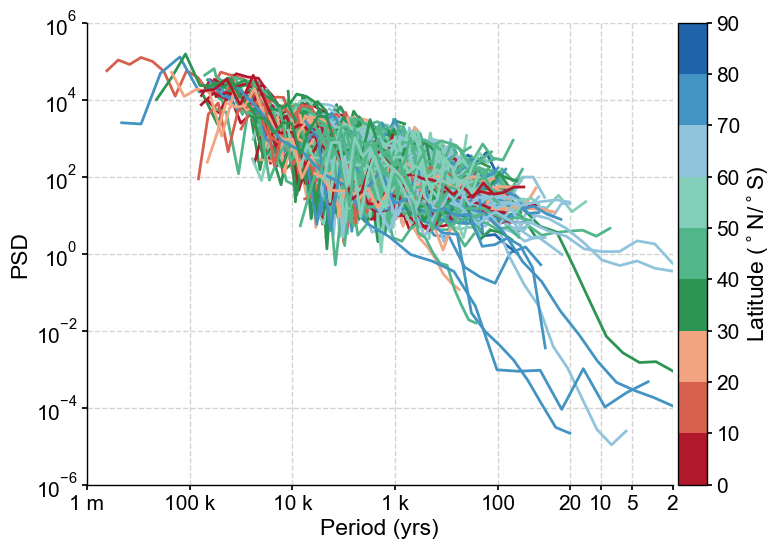

In [67]:
# define a colormap for different latitudes
with open('../data/temp_12k_lats', 'rb') as f:
    lats = pickle.load(f)
    
lat_list = [v for k, v in lats.items()]
cmap = sns.color_palette("RdBu_r", 9)[::-1]
cmap_green = sns.color_palette("BuGn_r")
cmap[3:6] = cmap_green[1:4]
color_ind_list = np.abs(lat_list)//10
color_ind_list = color_ind_list.astype(int)

# plot the PSD curves colored according to latitudes
    
# set the plotting style
pyleo.set_style(style='journal', font_scale=1.5)

period_ticks = [2, 5, 10, 20, 100, 1000, 10000, 100000, 1000000]
period_ticklabels = ['2', '5', '10', '20', '100', '1 k', '10 k', '100 k', '1 m']
    
dsns = psd.keys()
psd_obj = psd[list(dsns)[0]]
fig, ax = psd_obj.plot(figsize=[8, 6]) # plot the first PSD curve
for dsn, psd_obj in psd.items():
    # loop over and plot the PSD curves of other records
    if dsn == list(dsns)[0]:
        pass
    else:
        i = list(dsns).index(dsn)
        psd_obj.plot(
            ax=ax, xlim=[1e6, 1e1], ylim=[1e-6, 1e6],
            xlabel='Period (yrs)', ylabel='PSD',
            color=cmap[color_ind_list[i]],
        )
        
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)
        
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
clr_map = mpl.colors.ListedColormap(cmap)
cax = divider.append_axes("right", size="5%", pad=0.05)
bounds = np.linspace(0, 90, 10)
norm = mpl.colors.Normalize(vmin=bounds[0], vmax=bounds[-1])
cb = mpl.colorbar.ColorbarBase(cax, cmap=clr_map, orientation='vertical',norm=norm,boundaries=bounds)
cb.set_label(r'Latitude ($^\circ$N/$^\circ$S)')

The PSD curves are now plotted, it's time to visualize the estimated scaling slopes - the $\beta$ values.

Below we show how to plot KDE of the $\beta$ values of those PSD curves utilizating another visualization package [seaborn](https://seaborn.pydata.org).

Text(0.5, 0, '$\\beta$')

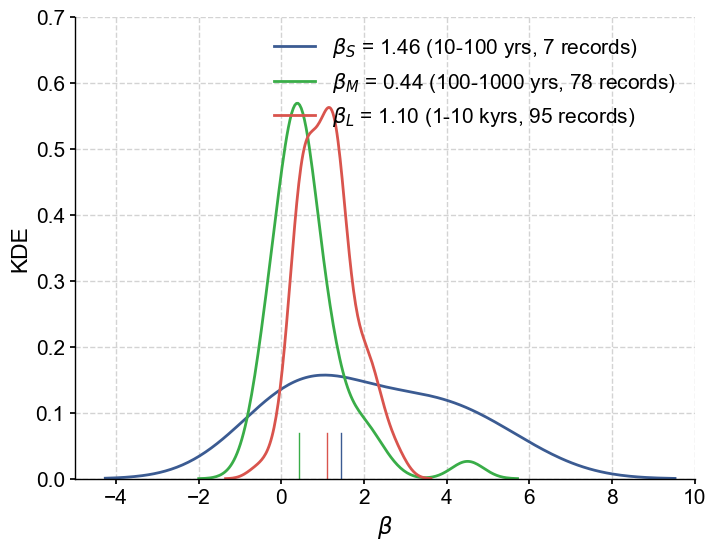

In [68]:
# set the plotting style
pyleo.set_style(style='journal', font_scale=1.5)

fig, ax = plt.subplots(figsize=[8, 6])
med_s = np.median(beta_S)
med_m = np.median(beta_M)
med_l = np.median(beta_L)
n_s = beta_S.shape[0]
n_m = beta_M.shape[0]
n_l = beta_L.shape[0]

ax.set_xlim([-5, 10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

g1 = sns.kdeplot(beta_S, shade=False, color=sns.xkcd_rgb['denim blue'], linestyle='-',
                 label=r'$\beta_S$ = {:.2f} (10-100 yrs, {} records)'.format(med_s, n_s))
g1.axvline(x=med_s, ymin=0, ymax=0.1, linewidth=1, color=sns.xkcd_rgb['denim blue'],
           linestyle='-')

g2 = sns.kdeplot(beta_M, shade=False, color=sns.xkcd_rgb['medium green'], linestyle='-',
                 label=r'$\beta_M$ = {:.2f} (100-1000 yrs, {} records)'.format(med_m, n_m))
g2.axvline(x=med_m, ymin=0, ymax=0.1, linewidth=1, color=sns.xkcd_rgb['medium green'], linestyle='-')

g3 = sns.kdeplot(beta_L, shade=False, color=sns.xkcd_rgb['pale red'], linestyle='-',
                 label=r'$\beta_L$ = {:.2f} (1-10 kyrs, {} records)'.format(med_l, n_l))
g3.axvline(x=med_l, ymin=0, ymax=0.1, linewidth=1, color=sns.xkcd_rgb['pale red'], linestyle='-')

ax.set_ylim(0, 0.7)
ax.legend(fontsize=15, loc='upper right',  bbox_to_anchor=(1, 1))
ax.set_ylabel('KDE')
ax.set_xlabel(r'$\beta$')

We see that scaling exponents cover a broad range. Similar methods can be applied to explore how scaling behavior is affected by various factors, including archive type.  